In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.path.abspath(os.path.join(os.getcwd(),".."))
print(path)
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from dynamics_networks import DynamicsNetwork, DynamicsParamsOptimizer, EncoderDynamicsNetwork, EncoderDecoderDynamicsNetwork, VAEDynamicsNetwork
from rl.policy_networks import DPG_PolicyNetwork
from utils.load_params import load_params
from utils.common_func import rand_params
from defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from environment import envs
import torch

/home/zihan/Research/PKU/sim2rel_system_id


In [12]:
env_name = 'halfcheetah'
data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
param_dim = len(DYNAMICS_PARAMS[env_name+'dynamics'])
print('parameter dimension: ', param_dim)

parameter dimension:  13


In [18]:
def output_m_std(data):
    data = np.array(data)
    for i in range(data.shape[1]):
        d=data.T[i]
        print(np.mean(d), np.std(d))

In [19]:
test_data = np.load(data_path, allow_pickle=True)
print('number of samples in test data: ', len(test_data))
idx=5  # index of sample to test: 0-10

# normalize s and s_
[s_norm_mean, s_norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor_s.npy'.format(env_name))
[s__norm_mean, s__norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor_s_.npy'.format(env_name))
s_dim = envs[env_name].observation_space.shape[0]
print(s_dim)
sa = test_data[idx]['sa']
s_ = test_data[idx]['s_']
sa = np.vstack(sa)
# print(output_m_std(s_))
sa = np.concatenate([(sa[:, :s_dim] - s_norm_mean)/s_norm_std, sa[:, s_dim:]], axis=-1)
s_ = (s_ - s__norm_mean)/s__norm_std

print(output_m_std(sa[:, :s_dim]), output_m_std(s_))
params = test_data[idx]['params'] # true parameters
sa = torch.Tensor(sa)
s_ = torch.Tensor(s_)
print(sa.shape, s_.shape)
print('true parameters: ', params)

number of samples in test data:  10
17
-0.5434495903160826 1.2404702873087172
0.2940544981143391 1.1632233217205186
-0.2783436924782656 0.7766032600606889
-0.27918425927808255 1.1400359346277806
-0.10068791027128435 1.0726285529817852
0.2405469644462648 1.0564750155683262
0.16736324719695264 0.7927107904523644
0.2349489852083864 1.0777291198219274
-0.4855587749722446 0.8625718611679377
0.01668262244810763 0.8178531154687724
0.020974186439968207 0.8726445977972502
-0.009886491340056865 0.7372456972259316
-0.00021815043205878902 0.968286634768646
-0.012986451012561651 0.9374700780552667
-0.011435450355085952 0.9169860795491068
-0.0056587181820240365 0.9265581947570297
0.022438478678946834 0.857298270441421
-0.5440014676144178 1.2403901409830158
0.2944527329644495 1.1631714599492562
-0.27857006374519916 0.7765708612237066
-0.27950963440245374 1.139911431919678
-0.10091508373894821 1.0725735848357476
0.24079416064735568 1.056409417443303
0.1676315280021635 0.792593617959314
0.2353000872326

## 1. Direct optimization through NN

In [15]:
def train_params(Env, embedding, epoch=1000, lr=1e-2, dynamics_model_path='./', env_settings={}, default_params={}, data_path='./'):
    """
    Train the dynamics parameters with a trained/fixed dynamics prediction model, using the real-world dataset.
    Model input: state, action, dynamics parameters (learnable).
    Model output: next state.
    """
    env = Env(**env_settings, **default_params)
    if embedding:
        param_dim = HYPER_PARAMS[Env.name+'dynamics']['latent_dim']
        param_ini_v = np.zeros(param_dim)
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=6, lr=lr)
    else:
        param_dim = len(DYNAMICS_PARAMS[Env.name+'dynamics'])
        param_ini_v = [np.mean(v) for k, v in env.parameters_spec.items() if k in DYNAMICS_PARAMS[Env.name+'dynamics']]
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=6, lr=lr)
    model.dynamics_model.load_state_dict(torch.load(dynamics_model_path))
    model.dynamics_model.eval()

#     sa = np.load(data_path+'/sa.npy')
#     s_ = np.load(data_path+'/s_.npy')

    for ep in range(epoch):
        s_pred = model.forward(sa)
        model.optimizer.zero_grad()
        loss = model.criterion(s_pred, s_)
        loss.backward()
        model.optimizer.step()
        if ep%100==0:
            print('epoch: {}, loss: {}'.format(ep, loss.item()))
        
    return model.params

In [16]:
Env = envs[env_name]  # pandapushik2dsimple', 'inverteddoublependulum'
Type = ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork', 'VAEDynamicsNetwork'][2]

alpha = train_params(Env, embedding=True, \
              dynamics_model_path=path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim)), \
                   lr=1e-3,   epoch=1, data_path=data_path)
print('Method 1: predicted encoded parameters: ', alpha)

AttributeError: 'NoneType' object has no attribute 'size'

In [17]:
from dynamics_predict.dynamics_networks import DynamicsEncoder, DynamicsVariationalEncoder

# load encoder
if Type in ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork']:  # normal encoder
    encoder = DynamicsEncoder(param_dim=len(DYNAMICS_PARAMS[env_name+'dynamics']), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # latent dimension needs to align with the trained DynamicsEncoder 
elif Type == 'VAEDynamicsNetwork': # variational auto-encoder
    encoder = DynamicsVariationalEncoder(param_dim=len(DYNAMICS_PARAMS[env_name+'dynamics']), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # 
encoder.load_state_dict(torch.load(path+'/data/dynamics_data/{}/model/{}_dim{}/encoder'.format(env_name, Type, str(len(DYNAMICS_PARAMS[env_name+'dynamics'])))))
encoder.eval()

# normalize the data
[norm_mean, norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor.npy'.format(env_name))
print('norm factors: ', norm_mean, norm_std)
params_ = (params - norm_mean)/norm_std
params_ = torch.FloatTensor([params_])
# print(params.shape)
mu, logvar = encoder(params_)
true_alpha = mu.detach().cpu().numpy()[0]
print('true encoded parameters: ', true_alpha)

norm factors:  [  9.785748    6.0115314   4.459795    2.989853    4.546878    2.96446
   1.5177193 240.45085   181.35234   117.35172   180.50174   121.0414
  60.44303  ] [ 2.4345038  1.7292134  1.7088287  1.1479716  1.7420182  1.1515262
  0.7528462 79.59281   91.298706  63.482002  92.53913   57.7959
 28.761574 ]
true encoded parameters:  [-0.09248241  0.5704723   0.68570143  0.28998855]


## Bayesian optimization

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from environment import envs
from dynamics_predict.defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from bayes_opt import BayesianOptimization
from dynamics_predict.dynamics_networks import DynamicsNetwork


class EmbeddingBayesianOptimization():
    def __init__(self, Env_name, data_path, dynamics_model_path):
        self.x=sa
        self.y=s_
#         self.x = tocrch.Tensor(np.load(data_path+'sa.npy'))
#         self.y = torh.Tensor(np.load(data_path+'s_.npy'))
        env = envs[Env_name]()
        self.env_name = Env_name
        self.dynamics_model = DynamicsNetwork(state_space=env.observation_space, action_space=env.action_space, \
                                              num_hidden_layers=6, param_dim=HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])
        self.dynamics_model.load_state_dict(torch.load(dynamics_model_path))

    def get_params_bound(self,):
        v_limit = 2.
        bounds = {'alpha_{}'.format(i): [-v_limit, v_limit] for i in range(HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])}
        return bounds
    
    def black_box_function(self, **alpha):
        """Function with unknown internals we wish to maximize.
        This is just serving as an example, for all intents and
        purposes think of the internals of this function, i.e.: the process
        which generates its output values, as unknown.
        """
        x=torch.cat((self.x, torch.Tensor(list(alpha.values())).repeat(self.x.shape[0],1)),axis=-1)
        y_=self.dynamics_model(x).detach().cpu().numpy()

        loss = np.square(np.subtract(self.y, y_)).mean()

        return -loss  # BO gives the maximum, so negagive loss


    def optimize(self, random_init=50, n_iter=500, result_path='params_bo.npy'):
        params_bound = self.get_params_bound()

        optimizer = BayesianOptimization(
            f=self.black_box_function,
            pbounds=params_bound,  # Here it defines the parameters to be randomized, which should also match with input arguments of black_box_function()
            verbose=2,  # verbose =2 print each iteration, verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
        )
        
        optimizer.probe(  # probe a certain datapoint at the beginning
#         params={"alpha_0": -1.0045, "alpha_1": 0.3682}, lazy=True)
        params={"alpha_0": 0.60418, "alpha_1": -0.01851, "alpha_2":0.0065969, "alpha_3": -0.008073 }, lazy=True)

        optimizer.maximize(
            init_points=random_init,
            n_iter=n_iter,
        )

        print(optimizer.max['params'])
        optimized_params = optimizer.max['params']
        np.save(result_path, [params_bound, optimized_params])
        return optimizer.res


In [9]:
dynamics_model_path = path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim))

data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'

ebo = EmbeddingBayesianOptimization(env_name, data_path, dynamics_model_path)
optimization_records = ebo.optimize()
# np.save('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), optimization_records)

|   iter    |  target   |  alpha_0  |  alpha_1  |  alpha_2  |  alpha_3  |
-------------------------------------------------------------------------
|  1        | -0.1285   |  0.6042   | -0.01851  |  0.006597 | -0.008073 |
|  2        | -0.4347   | -0.3319   |  0.8813   | -2.0      | -0.7907   |
|  3        | -0.5416   | -1.413    | -1.631    | -1.255    | -0.6178   |
|  4        | -0.2265   | -0.4129   |  0.1553   | -0.3232   |  0.7409   |
|  5        | -0.4975   | -1.182    |  1.512    | -1.89     |  0.6819   |
|  6        | -0.2572   | -0.3308   |  0.2348   | -1.438    | -1.208    |
|  7        | -0.5268   |  1.203    |  1.873    | -0.7463   |  0.7693   |
|  8        | -0.5802   |  1.506    |  1.578    | -1.66     | -1.844    |
|  9        | -0.5099   | -1.321    |  1.513    | -1.607    | -0.3156   |
|  10       | -0.1083   |  1.832    |  0.1327   |  0.7675   | -0.7379   |
|  11       | -0.4688   |  0.746    |  1.339    | -1.927    |  1.001    |
|  12       | -0.3969   |  1.955    | 

|  67       | -0.1052   |  0.9827   |  0.01584  |  0.8124   | -2.0      |
|  68       | -0.125    | -2.0      | -0.3033   | -0.05701  | -1.046    |
|  69       | -0.1161   | -0.9399   | -0.3634   |  2.0      |  0.2245   |
|  70       | -0.1021   |  1.074    | -0.1277   |  0.8693   | -0.9449   |
|  71       | -0.1044   |  0.9805   |  0.1977   |  2.0      |  0.2599   |
|  72       | -0.179    | -1.466    |  0.4047   |  2.0      | -0.05877  |
|  73       | -0.2189   | -0.4574   | -0.5142   |  2.0      |  2.0      |
|  74       | -0.115    | -0.5106   |  0.00352  |  1.011    | -2.0      |
|  75       | -0.1509   |  2.0      | -0.3169   |  1.371    | -0.7802   |
|  76       | -0.1242   |  2.0      |  0.3492   |  2.0      |  0.8804   |
|  77       | -0.1279   |  1.246    | -0.1198   | -0.04954  | -1.182    |
|  78       | -0.1285   |  2.0      |  0.2113   |  0.7464   | -2.0      |
|  79       | -0.09137  |  0.09561  | -0.08821  |  1.681    | -1.158    |
|  80       | -0.09254  |  0.1072   | 

|  134      | -0.08564  |  0.549    |  0.02119  |  1.709    | -0.1567   |
|  135      | -0.08585  |  0.6244   | -0.06169  |  0.7964   |  0.4875   |
|  136      | -0.08027  |  0.3967   | -0.05128  |  1.142    |  0.251    |
|  137      | -0.09128  |  1.024    |  0.006468 |  1.581    | -0.9688   |
|  138      | -0.08337  | -0.3623   | -0.133    |  0.9249   | -0.008359 |
|  139      | -0.08395  |  0.1528   | -0.07222  |  1.757    |  0.09071  |
|  140      | -0.0817   |  0.01552  | -0.1312   |  1.239    |  0.3491   |
|  141      | -0.084    |  0.8303   | -0.000531 |  1.084    |  0.1801   |
|  142      | -0.0871   |  1.136    |  0.07063  |  1.431    |  0.326    |
|  143      | -0.1315   |  2.0      |  0.07732  |  0.2182   | -1.088    |
|  144      | -0.08482  | -0.02545  | -0.1639   |  0.9582   |  0.03976  |
|  145      | -0.08678  | -0.02594  | -0.06989  |  1.128    | -0.8882   |
|  146      | -0.08736  | -0.6974   | -0.09556  |  1.163    |  0.4906   |
|  147      | -0.08922  | -0.4048   | 

|  202      | -0.08207  |  0.3038   | -0.07243  |  1.041    | -0.03503  |
|  203      | -0.08389  |  0.7349   | -0.02163  |  1.188    |  0.6778   |
|  204      | -0.08225  |  0.4847   | -0.04633  |  1.024    |  0.6481   |
|  205      | -0.08449  | -0.29     | -0.03471  |  1.268    |  0.4412   |
|  206      | -0.09408  | -0.2946   | -0.2493   |  0.6337   | -0.7708   |
|  207      | -0.08455  | -0.2833   | -0.08842  |  1.467    | -0.242    |
|  208      | -0.08031  |  0.07918  | -0.1042   |  1.102    |  0.2906   |
|  209      | -0.08089  | -0.08369  | -0.04986  |  1.169    |  0.4362   |
|  210      | -0.08057  |  0.08101  | -0.09072  |  0.9969   |  0.1562   |
|  211      | -0.08186  | -0.3451   | -0.09423  |  1.037    |  0.2479   |
|  212      | -0.08785  | -0.265    | -0.116    |  1.794    | -0.4001   |
|  213      | -0.08178  |  0.4395   | -0.04785  |  1.463    |  0.1046   |
|  214      | -0.09523  | -1.179    | -0.1703   |  1.291    |  0.2116   |
|  215      | -0.07973  |  0.0735   | 

|  270      | -0.08106  |  0.2717   | -0.05399  |  1.012    |  0.07732  |
|  271      | -0.083    | -0.3801   | -0.1416   |  1.052    |  0.4684   |
|  272      | -0.08741  | -0.5788   | -0.1339   |  0.8485   |  0.6187   |
|  273      | -0.08145  |  0.1023   | -0.1116   |  1.103    |  0.07605  |
|  274      | -0.08089  |  0.2044   | -0.04091  |  0.9391   |  0.5084   |
|  275      | -0.08112  |  0.279    | -0.03591  |  1.407    |  0.08829  |
|  276      | -0.08253  |  0.7306   |  0.01081  |  1.225    |  0.4854   |
|  277      | -0.08204  |  0.4402   | -0.07005  |  1.406    |  0.4146   |
|  278      | -0.08075  |  0.3122   | -0.0177   |  1.265    |  0.4673   |
|  279      | -0.08111  | -0.03744  | -0.09498  |  1.036    |  0.5792   |
|  280      | -0.08103  |  0.2945   | -0.04222  |  1.45     |  0.1682   |
|  281      | -0.08298  |  0.07223  | -0.0613   |  1.133    | -0.3268   |
|  282      | -0.08252  | -0.08607  | -0.05795  |  1.508    |  0.3838   |
|  283      | -0.08261  |  0.1719   | 

|  338      | -0.08157  |  0.1715   | -0.09985  |  1.202    |  0.01084  |
|  339      | -0.08286  | -0.1835   | -0.07951  |  1.363    | -0.1253   |
|  340      | -0.08339  |  0.003919 | -0.09542  |  1.196    | -0.4535   |
|  341      | -0.07965  |  0.1255   | -0.06411  |  1.198    |  0.3745   |
|  342      | -0.08047  |  0.3839   | -0.0137   |  1.242    |  0.3028   |
|  343      | -0.08158  |  0.09485  | -0.04051  |  1.445    |  0.09525  |
|  344      | -0.08116  |  0.4497   | -0.02277  |  0.9804   |  0.4864   |
|  345      | -0.0808   | -0.04568  | -0.09497  |  1.132    |  0.551    |
|  346      | -0.08244  | -0.1988   | -0.1162   |  0.935    | -0.03033  |
|  347      | -0.08295  |  0.2281   | -0.04703  |  1.47     | -0.2581   |
|  348      | -0.08082  | -0.08015  | -0.07962  |  1.367    |  0.2125   |
|  349      | -0.08115  | -0.2021   | -0.1102   |  0.9476   |  0.2568   |
|  350      | -0.08313  |  0.6191   | -0.04014  |  1.534    |  0.2519   |
|  351      | -0.08394  | -0.2561   | 

|  406      | -0.08302  |  0.596    | -0.072    |  1.041    |  0.4976   |
|  407      | -0.08152  | -0.1006   | -0.1361   |  1.117    |  0.2435   |
|  408      | -0.08073  |  0.2242   | -0.07823  |  1.005    |  0.151    |
|  409      | -0.08204  |  0.2786   | -0.06201  |  1.254    | -0.1596   |
|  410      | -0.08061  | -0.009716 | -0.1119   |  1.135    |  0.1963   |
|  411      | -0.08517  |  0.01529  | -0.1203   |  1.677    | -0.2152   |
|  412      | -0.08454  |  0.3298   | -0.0255   |  0.9924   |  0.8541   |
|  413      | -0.08212  | -0.0315   | -0.1161   |  0.9651   |  0.5732   |
|  414      | -0.0811   | -0.1415   | -0.1275   |  1.127    |  0.3555   |
|  415      | -0.08211  |  0.1796   | -0.0337   |  0.8698   |  0.5453   |
|  416      | -0.08199  | -0.1824   | -0.1299   |  0.9034   |  0.2214   |
|  417      | -0.08342  |  0.1921   | -0.03167  |  1.192    | -0.3227   |
|  418      | -0.08133  | -0.07016  | -0.06295  |  1.417    |  0.3187   |
|  419      | -0.08149  | -0.2097   | 

KeyboardInterrupt: 

0.08903758034978493 -0.6559236800451966


NameError: name 'true_alpha' is not defined

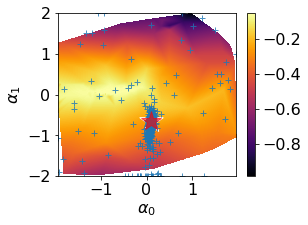

In [5]:
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.interpolate
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

idx=3
font = {
#         'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 16}
optimization_records = np.load('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), allow_pickle=True)
matplotlib.rc('font', **font)
alpha_id = [0,1]  # select plotted alphas here
z=[]
x=[]
y=[]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_{}'.format(str(alpha_id[0]))])
    y.append(res['params']['alpha_{}'.format(str(alpha_id[1]))])

x=np.array(x)
y=np.array(y)
z=np.array(z)

# the optimal point found by BO
x_bo = x[np.argmax(z)]
y_bo = y[np.argmax(z)]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
values = scipy.interpolate.griddata((x, y), z, (grid_x, grid_y), method='linear')
plt.figure(figsize=(4,3))
plt.imshow(values, origin='lower', extent=[xmin, xmax, ymin, ymax],
          aspect='auto', cmap='inferno')
plt.plot(x,y, '+', alpha=0.8)
plt.xlabel(r'$\alpha_{}$'.format(str(alpha_id[0])))
plt.ylabel(r'$\alpha_{}$'.format(str(alpha_id[1])))
plt.colorbar()
print(x_bo, y_bo)
plt.scatter(x_bo, y_bo, s=600, marker="*", c='white')
# plt.scatter(*true_alpha, s=300, marker=".", c='red', alpha=0.8)
plt.plot(x_bo, y_bo, "*", c='red', markersize=20, alpha=0.6)
print(*true_alpha)
plt.plot(*true_alpha[alpha_id], '^', c='lime', markersize=10, alpha=0.8)

plt.savefig('../data/imgs/{}/bo{}_{}{}.pdf'.format(env_name, idx, alpha_id[0], alpha_id[1]), bbox_inches='tight')
plt.show()


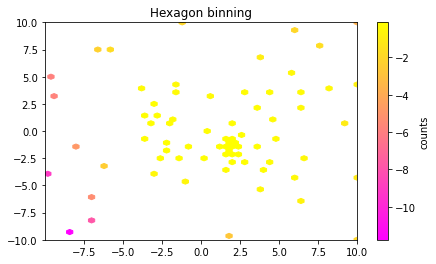

In [117]:
from matplotlib.colors import LogNorm
from matplotlib import cm

z=[]
x=[]
y=[]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_0'])
    y.append(res['params']['alpha_1'])
# x = y = np.linspace(-10, 10, 300)
# X, Y = np.meshgrid(x, y)
# x = X.ravel()
# y = Y.ravel()
x=np.array(x)
y=np.array(y)
z=np.array(z)
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(7, 4))
# fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs # ax = axs[k]
hb = ax.hexbin(x, y, C=z, gridsize=50, cmap='spring', bins=None)  # 'inferno'
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
# plt.colorbar()
plt.show()

In [49]:
import torch
t = torch.tensor([[1,2],[3,4]])
torch.gather(t, 1, torch.tensor([[0],[1]]))

tensor([[1],
        [4]])